<a href="https://colab.research.google.com/github/MyeongGuJo/hayaku-250322/blob/main/hayaku_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from ipywidgets import interact, fixed
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

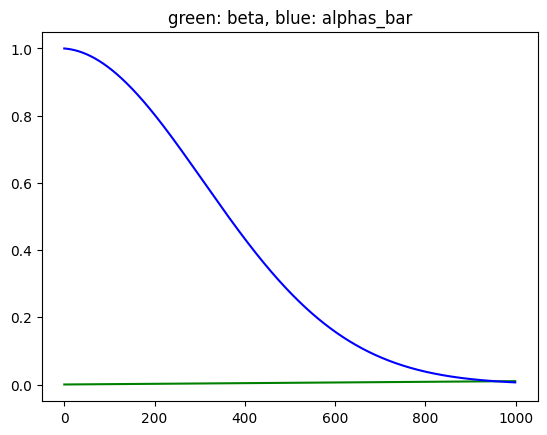

In [ ]:
n_step = 1000
beta_start = 0.0001
beta_end = 0.01
scale = 1000 / n_step # T = 1000 ->. scale = 1

betas = torch.linspace(beta_start * scale, beta_end * scale, n_step)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

plt.plot(betas, 'g')
plt.plot(alphas_bar, 'b')
plt.title('green: beta, blue: alphas_bar')
plt.show()

alphas_bar = alphas_bar.to(device)
betas = betas.to(device)
alphas = alphas.to(device)

In [ ]:
def extract(arr, t, x_shape):
    if not torch.is_tensor(t):
        b = 1
        t = torch.tensor(t).to(device)
    else:
        b = t.shape[0]

    out = arr.gather(-1, t) # array의 t번쨰 index를 가져와서 새로운 tensor로 만들어줌
    return out.view((b, ) + (1, ) * (len(x_shape) - 1))

def diffuse_once(x, t):
    return (1 - betas[t]).sqrt() * x + betas[t].sqrt() * torch.randn_like(x)

def diffuse(x, t, eta=None):
    if eta is None:
        eta = torch.randn_like(x).to(device)

    x_t = extract(alphas_bar.sqrt(), t, x.shape) * x + extract((1 - alphas_bar).sqrt(), t, x.shape) * eta

    return x_t

In [ ]:
'''
3d UNet
'''

import math

class TimeEmbedding_UNet(nn.Module):
    def __init__(self, emb_dim: int):
        super().__init__()
        self.emb_dim = emb_dim
        self.lin1 = nn.Linear(self.emb_dim // 4, self.emb_dim)
        self.lin2 = nn.Linear(self.emb_dim, self.emb_dim)
        self.act = nn.SiLU()

    def forward(self, t: torch.Tensor):
        half_dim = self.emb_dim // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        return emb


class Residual_UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.SiLU()
        )

        self.time_emb = TimeEmbedding_UNet(out_channels)

        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.SiLU()
        )

    def forward(self, x, t):
        x = self.conv1(x)
        t_emb = self.time_emb(t)
        x = self.conv2(x + t_emb[:, :, None, None, None])

        return x


# 3D Attention Gate 모듈 정의 (encoder의 특징 x와 디코더의 gating signal g를 받아 attention map을 구한 뒤, x에 곱해줌)
class AttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        Args:
            F_g: gating signal의 채널 수 (디코더에서 온 특징)
            F_l: encoder의 skip connection 특징 채널 수
            F_int: 중간 채널 수 (보통 F_l의 절반 정도)
        """
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        # x: encoder의 skip 특징, g: 디코더의 gating signal (보통 업샘플된 특징)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        # psi의 값(0~1)로 encoder 특징을 스케일링
        return x * psi


class Unet(nn.Module):
    def __init__(self, channels: list, n_steps: int):
        super().__init__()

        self.channels = channels
        self.n_steps = n_steps

        self.down1 = Residual_UNet(1, self.channels[0])
        self.down2 = Residual_UNet(self.channels[0], self.channels[1])
        self.down3 = Residual_UNet(self.channels[1], self.channels[2])

        # attention gate는 skip connection에 적용합니다.
        # upsample1 이후의 gating signal x (채널 수 channels[2])로 conv2 (채널 수 channels[1])를 조절합니다.
        self.att_gate2 = AttentionGate3D(F_g=self.channels[2], F_l=self.channels[1], F_int=self.channels[1] // 2)
        # upsample2 이후의 gating signal x (채널 수 channels[1])로 conv1 (채널 수 channels[0])를 조절합니다.
        self.att_gate1 = AttentionGate3D(F_g=self.channels[1], F_l=self.channels[0], F_int=self.channels[0] // 2)

        self.up1 = Residual_UNet(self.channels[2] + self.channels[1], self.channels[1])
        self.up2 = Residual_UNet(self.channels[1] + self.channels[0], self.channels[0])

        self.upsample1 = nn.ConvTranspose3d(self.channels[2], self.channels[2], kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.upsample2 = nn.ConvTranspose3d(self.channels[1], self.channels[1], kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.maxpool = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.final = nn.Sequential(
            nn.Conv3d(self.channels[0] + 1, self.channels[0], 3, padding=1),
            nn.BatchNorm3d(self.channels[0]),
            nn.SiLU(),
            nn.Conv3d(self.channels[0], 1, 3, padding=1)
        )

    def forward(self, x, t):
        input_data = x.clone()
        t = t.float() / self.n_steps

        conv1 = self.down1(x, t)
        x = self.maxpool(conv1)

        conv2 = self.down2(x, t)
        x = self.maxpool(conv2)

        x = self.down3(x, t)

        x = self.upsample1(x)     #upsampling

        conv2_att = self.att_gate2(conv2, x)
        x = torch.cat([x, conv2_att], dim=1)
        x = self.up1(x, t)

        x = self.upsample2(x)     #upsampling
        conv1_att = self.att_gate1(conv1, x)
        x = torch.cat([x, conv1_att], dim=1)
        x = self.up2(x, t)

        x = torch.cat([x, input_data], dim=1)
        x = self.final(x)

        return x

In [ ]:
'''
3d UNet
'''

import math

class TimeEmbedding_UNet_CFG(nn.Module):
    def __init__(self, emb_dim: int):
        super().__init__()
        self.emb_dim = emb_dim
        self.lin1 = nn.Linear(self.emb_dim // 4, self.emb_dim)
        self.lin2 = nn.Linear(self.emb_dim, self.emb_dim)
        self.act = nn.SiLU()

    def forward(self, t: torch.Tensor):
        half_dim = self.emb_dim // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        return emb


class Residual_UNet_CFG(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.SiLU()
        )

        self.time_emb = TimeEmbedding_UNet_CFG(out_channels)

        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.SiLU()
        )

    def forward(self, x, t):
        x = self.conv1(x)
        t_emb = self.time_emb(t)
        x = self.conv2(x + t_emb[:, :, None, None, None])

        return x


# 3D Attention Gate 모듈 정의 (encoder의 특징 x와 디코더의 gating signal g를 받아 attention map을 구한 뒤, x에 곱해줌)
class AttentionGate3D_CFG(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        Args:
            F_g: gating signal의 채널 수 (디코더에서 온 특징)
            F_l: encoder의 skip connection 특징 채널 수
            F_int: 중간 채널 수 (보통 F_l의 절반 정도)
        """
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        # x: encoder의 skip 특징, g: 디코더의 gating signal (보통 업샘플된 특징)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        # psi의 값(0~1)로 encoder 특징을 스케일링
        return x * psi


class ClassEmbedding_CFG(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(num_classes, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

    def forward(self, c):
        return self.embedding(c)


class Unet_CFG(nn.Module):
    def __init__(self, channels: list, n_steps: int, class_num: int):
        super().__init__()

        self.channels = channels
        self.n_steps = n_steps
        self.class_num = class_num

        self.down1 = Residual_UNet_CFG(1, self.channels[0])
        self.down2 = Residual_UNet_CFG(self.channels[0], self.channels[1])
        self.down3 = Residual_UNet_CFG(self.channels[1], self.channels[2])

        # attention gate는 skip connection에 적용합니다.
        # upsample1 이후의 gating signal x (채널 수 channels[2])로 conv2 (채널 수 channels[1])를 조절합니다.
        self.att_gate2 = AttentionGate3D_CFG(F_g=self.channels[2], F_l=self.channels[1], F_int=self.channels[1] // 2)
        # upsample2 이후의 gating signal x (채널 수 channels[1])로 conv1 (채널 수 channels[0])를 조절합니다.
        self.att_gate1 = AttentionGate3D_CFG(F_g=self.channels[1], F_l=self.channels[0], F_int=self.channels[0] // 2)

        self.up1 = Residual_UNet_CFG(self.channels[2] + self.channels[1], self.channels[1])
        self.up2 = Residual_UNet_CFG(self.channels[1] + self.channels[0], self.channels[0])

        self.class_emb1 = ClassEmbedding_CFG(self.class_num, self.channels[2])
        self.class_emb2 = ClassEmbedding_CFG(self.class_num, self.channels[1])

        self.upsample1 = nn.ConvTranspose3d(self.channels[2], self.channels[2], kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.upsample2 = nn.ConvTranspose3d(self.channels[1], self.channels[1], kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.maxpool = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.final = nn.Sequential(
            nn.Conv3d(self.channels[0] + 1, self.channels[0], 3, padding=1),
            nn.BatchNorm3d(self.channels[0]),
            nn.SiLU(),
            nn.Conv3d(self.channels[0], 1, 3, padding=1)
        )

    def forward(self, x, t, c):
        input_data = x.clone()
        t = t.float() / self.n_steps

        conv1 = self.down1(x, t)
        x = self.maxpool(conv1)

        conv2 = self.down2(x, t)
        x = self.maxpool(conv2)

        x = self.down3(x, t)

        x = self.upsample1(x)     #upsampling

        c_emb1 = self.class_emb1(c)
        x = x * c_emb1[:, :, None, None, None]
        conv2_att = self.att_gate2(conv2, x)
        #print(x.shape)
        #print(c_emb1.shape)
        x = torch.cat([x, conv2_att], dim=1)
        x = self.up1(x, t)

        x = self.upsample2(x)     #upsampling

        c_emb2 = self.class_emb2(c)
        x = x * c_emb2[:, :, None, None, None]
        conv1_att = self.att_gate1(conv1, x)
        x = torch.cat([x, conv1_att], dim=1)
        x = self.up2(x, t)

        x = torch.cat([x, input_data], dim=1)
        x = self.final(x)

        return x

In [ ]:
'''
3 channels
import math

class TimeEmbedding_UNet(nn.Module):
    def __init__(self, emb_dim: int):
        super().__init__()
        self.emb_dim = emb_dim
        self.lin1 = nn.Linear(self.emb_dim // 4, self.emb_dim)
        self.lin2 = nn.Linear(self.emb_dim, self.emb_dim)
        self.act = nn.SiLU()

    def forward(self, t: torch.Tensor):
        half_dim = self.emb_dim // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        return emb


class Residual_UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )

        self.time_emb = TimeEmbedding_UNet(out_channels)

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )

    def forward(self, x, t):
        x = self.conv1(x)
        t_emb = self.time_emb(t)
        x = self.conv2(x + t_emb[:, :, None, None])

        return x


# 2D Attention Gate 모듈 정의 (encoder의 특징 x와 디코더의 gating signal g를 받아 attention map을 구한 뒤, x에 곱해줌)
class AttentionGate2D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        Args:
            F_g: gating signal의 채널 수 (디코더에서 온 특징)
            F_l: encoder의 skip connection 특징 채널 수
            F_int: 중간 채널 수 (보통 F_l의 절반 정도)
        """
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        # x: encoder의 skip 특징, g: 디코더의 gating signal (보통 업샘플된 특징)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        # psi의 값(0~1)로 encoder 특징을 스케일링
        return x * psi


class Unet(nn.Module):
    def __init__(self, channels: list, n_steps: int):
        super().__init__()

        self.channels = channels
        self.n_steps = n_steps

        self.down1 = Residual_UNet(3, self.channels[0])
        self.down2 = Residual_UNet(self.channels[0], self.channels[1])
        self.down3 = Residual_UNet(self.channels[1], self.channels[2])

        # attention gate는 skip connection에 적용합니다.
        # upsample1 이후의 gating signal x (채널 수 channels[2])로 conv2 (채널 수 channels[1])를 조절합니다.
        self.att_gate2 = AttentionGate2D(F_g=self.channels[2], F_l=self.channels[1], F_int=self.channels[1] // 2)
        # upsample2 이후의 gating signal x (채널 수 channels[1])로 conv1 (채널 수 channels[0])를 조절합니다.
        self.att_gate1 = AttentionGate2D(F_g=self.channels[1], F_l=self.channels[0], F_int=self.channels[0] // 2)

        self.up1 = Residual_UNet(self.channels[2] + self.channels[1], self.channels[1])
        self.up2 = Residual_UNet(self.channels[1] + self.channels[0], self.channels[0])

        self.upsample1 = nn.ConvTranspose2d(self.channels[2], self.channels[2], kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(self.channels[1], self.channels[1], kernel_size=2, stride=2)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.final = nn.Sequential(
            nn.Conv2d(self.channels[0] + 3, self.channels[0], 3, padding=1),
            nn.BatchNorm2d(self.channels[0]),
            nn.SiLU(),
            nn.Conv2d(self.channels[0], 3, 3, padding=1)
        )

    def forward(self, x, t):
        input_data = x.clone()
        t = t.float() / self.n_steps

        conv1 = self.down1(x, t)
        x = self.maxpool(conv1)

        conv2 = self.down2(x, t)
        x = self.maxpool(conv2)

        x = self.down3(x, t)

        x = self.upsample1(x)     #upsampling

        conv2_att = self.att_gate2(conv2, x)
        x = torch.cat([x, conv2_att], dim=1)
        x = self.up1(x, t)

        x = self.upsample2(x)     #upsampling
        conv1_att = self.att_gate1(conv1, x)
        x = torch.cat([x, conv1_att], dim=1)
        x = self.up2(x, t)

        x = torch.cat([x, input_data], dim=1)
        x = self.final(x)

        return x

'''

'\n3 channels\nimport math\n\nclass TimeEmbedding_UNet(nn.Module):\n    def __init__(self, emb_dim: int):\n        super().__init__()\n        self.emb_dim = emb_dim\n        self.lin1 = nn.Linear(self.emb_dim // 4, self.emb_dim)\n        self.lin2 = nn.Linear(self.emb_dim, self.emb_dim)\n        self.act = nn.SiLU()\n\n    def forward(self, t: torch.Tensor):\n        half_dim = self.emb_dim // 8\n        emb = math.log(10_000) / (half_dim - 1)\n        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)\n        emb = t[:, None] * emb[None, :]\n        emb = torch.cat((emb.sin(), emb.cos()), dim=1)\n\n        emb = self.act(self.lin1(emb))\n        emb = self.lin2(emb)\n\n        return emb\n    \n\nclass Residual_UNet(nn.Module):\n    def __init__(self, in_channels, out_channels):\n        super().__init__()\n\n        self.conv1 = nn.Sequential(\n            nn.Conv2d(in_channels, out_channels, 3, padding=1),\n            nn.BatchNorm2d(out_channels),\n            nn.SiL

In [ ]:
model = Unet_CFG(channels=[128, 192, 256], n_steps=n_step, class_num=8).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=4e-5)
criterion = nn.MSELoss()

print("model parameter size :", sum(p.numel() for p in model.parameters() if p.requires_grad))

model parameter size : 11320743


In [ ]:
class ContinuousMNISTDataset(Dataset):
    def __init__(self, root='./data', train=True, transform=transforms.ToTensor(), download=True, data_size=60000):
        """
        Args:
            root (str): Root directory for MNIST.
            train (bool): Use training set or test set.
            transform: Transform to apply to each MNIST image.
            download (bool): Download MNIST if not present.
            data_size (int): Number of samples (triplets) to generate.
        """
        # Load the standard MNIST dataset
        self.mnist = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.data_size = data_size

        # Build a dictionary mapping each digit (0-9) to a list of indices
        self.label_to_indices = {i: [] for i in range(10)}
        for idx, (_, label) in enumerate(self.mnist):
            self.label_to_indices[label].append(idx)

        # Allowed starting digits for a consecutive triplet (0-7)
        self.allowed_starts = list(range(8))

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):
        # Randomly choose a starting digit (ensuring the group is continuous)
        start_digit = random.choice(self.allowed_starts)
        images = []
        labels = []

        # For each digit in the triplet [start, start+1, start+2], randomly select an image
        for d in [start_digit, start_digit + 1, start_digit + 2]:
            idx = random.choice(self.label_to_indices[d])
            img, label = self.mnist[idx]
            images.append(img)
            labels.append(label)

        # Each image is (1, 28, 28). Use torch.stack to form a tensor of shape (3, 1, 28, 28)
        # Then, permute to obtain (1, 3, 28, 28) (channel, depth, height, width)
        images = torch.stack(images, dim=0)  # shape: (3, 1, 28, 28)
        images = images.permute(1, 0, 2, 3)    # shape: (1, 3, 28, 28)
        #images.squeeze_(0)

        images = (images * 2) - 1

        # Optionally, return labels as a tensor of three digits
        labels = torch.tensor(labels)
        return images, labels

In [ ]:
# Create an instance of the custom dataset with a desired size
dataset = ContinuousMNISTDataset(data_size=10000)

# Create a DataLoader for batching and shuffling
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(len(dataloader))

313


Batch: 0
Data shape: torch.Size([32, 1, 3, 28, 28])
Target shape: torch.Size([32, 3])


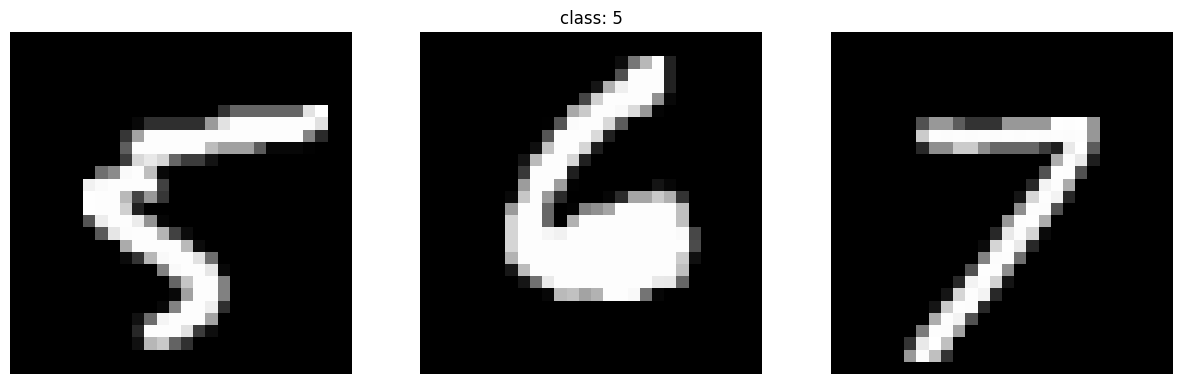

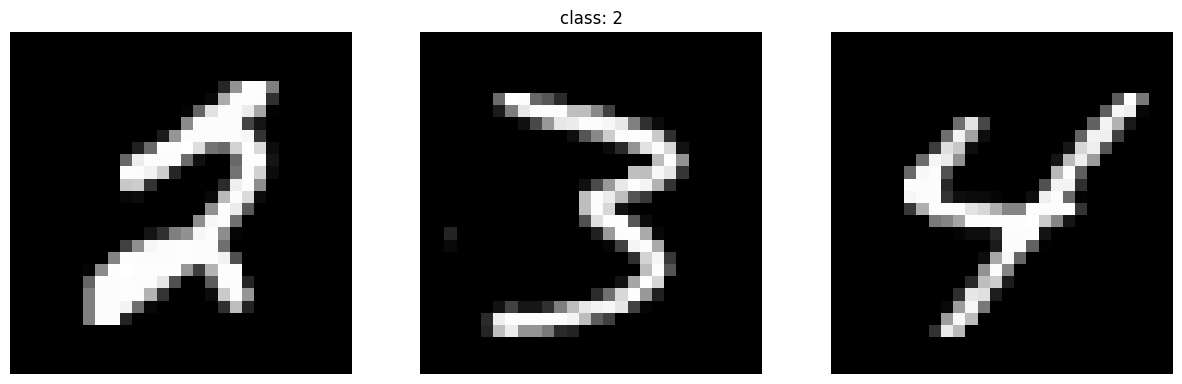

torch.Size([32, 1, 3, 28, 28])


In [ ]:
# Fetch a single batch and check the shape
for batch_idx, (data, target) in enumerate(dataloader):
    print('Batch:', batch_idx)
    print('Data shape:', data.shape)    # Expected: (32, 1, 3, 28, 28)
    print('Target shape:', target.shape)  # Expected: (32, 3)

    for j in range(2):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[1].title.set_text('class: %i' % target[j, 0])
        for j in range(3):
            ax[j].imshow(data[j, 0, j], cmap='gray', vmin=-1, vmax=1)
            ax[j].axis('off')
        plt.show()

    out_size = model(data.to(device), torch.arange(data.shape[0]).to(device), torch.zeros((data.shape[0], 8)).to(device)).shape
    print(out_size)
    break

In [ ]:
def get_context_mask(c, drop_prob, n_classes=8, device='cpu'):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=n_classes).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

print(get_context_mask(torch.tensor([0, 1, 2, 3, 4, 5, 6, 7]), 0.1))

(tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1]]), tensor([[0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]]))


In [ ]:
from tqdm import tqdm

num_epochs = 50

model.train()
for epoch in range(num_epochs):
    loader = tqdm(dataloader)
    losses = []

    for step, (data, target) in enumerate(loader):
        data = data.to(device, dtype=torch.float)
        c_hot, c_mask = get_context_mask(target[:, 0], 0.1, 8, device)

        t = torch.randint(0, n_step, size=(data.shape[0], )).to(device)
        eta = torch.randn_like(data).to(device)
        diffused = diffuse(data, t, eta).to(device)

        output = model(diffused, t, c_hot * c_mask)
        loss_value = criterion(output, eta)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        loader.set_description("step: %i, loss: %.4f" % (step, loss_value.detach().item()))
        losses.append(loss_value.detach().item())

    print("epoch %i final loss: %.6f" % (epoch, np.mean(losses)))

step: 26, loss: 0.0430:   9%|▊         | 27/313 [00:04<00:48,  5.86it/s]


KeyboardInterrupt: 

In [ ]:
def sample(c:torch.tensor, w=1):
    model.eval()
    with torch.no_grad():
        data = torch.randn((c.shape[0], 1, 3, 28, 28)).to(device)

        model.eval()
        for t in range(n_step - 1, -1, -1):  #[n_step - 1, 0], t + 1에서 t로
            z = 0

            if t > 0:
                z = torch.randn_like(data)

            sigma_t = torch.sqrt(betas[t])

            c_hot = F.one_hot(c.to(torch.int64), num_classes=8).to(dtype=torch.float, device=device)
            #print(c_hot.shape)
            pred_noise_keep_class = model(data, torch.tensor([t], dtype=torch.int, device=device), c_hot)
            pred_noise_drop_class = model(data, torch.tensor([t], dtype=torch.int, device=device), torch.zeros_like(c_hot))

            pred_noise = (1 + w) * pred_noise_keep_class - w * pred_noise_drop_class

            # update data
            data = (1 / torch.sqrt(alphas[t])) *\
                (data - (1 - alphas[t]) / torch.sqrt(1 - alphas_bar[t]) * pred_noise) +\
                sigma_t * z

        return data

In [ ]:
print(sample(1).shape)

In [ ]:
def show_cfg_continous(c:torch.tensor, w):
    data = sample(c=c, w=w).cpu().numpy()

    fig, ax = plt.subplots(c.shape[0], 3, figsize=(15, 5 * c.shape[0]))

    for i in range(c.shape[0]):
        ax[i, 1].title.set_text('class: %i, w: %i' % (c[i].item(), w))
        for j in range(3):
            ax[i, j].imshow(data[i, 0, j], cmap='gray', vmin=-1, vmax=1)
            ax[i, j].axis('off')
    plt.show()

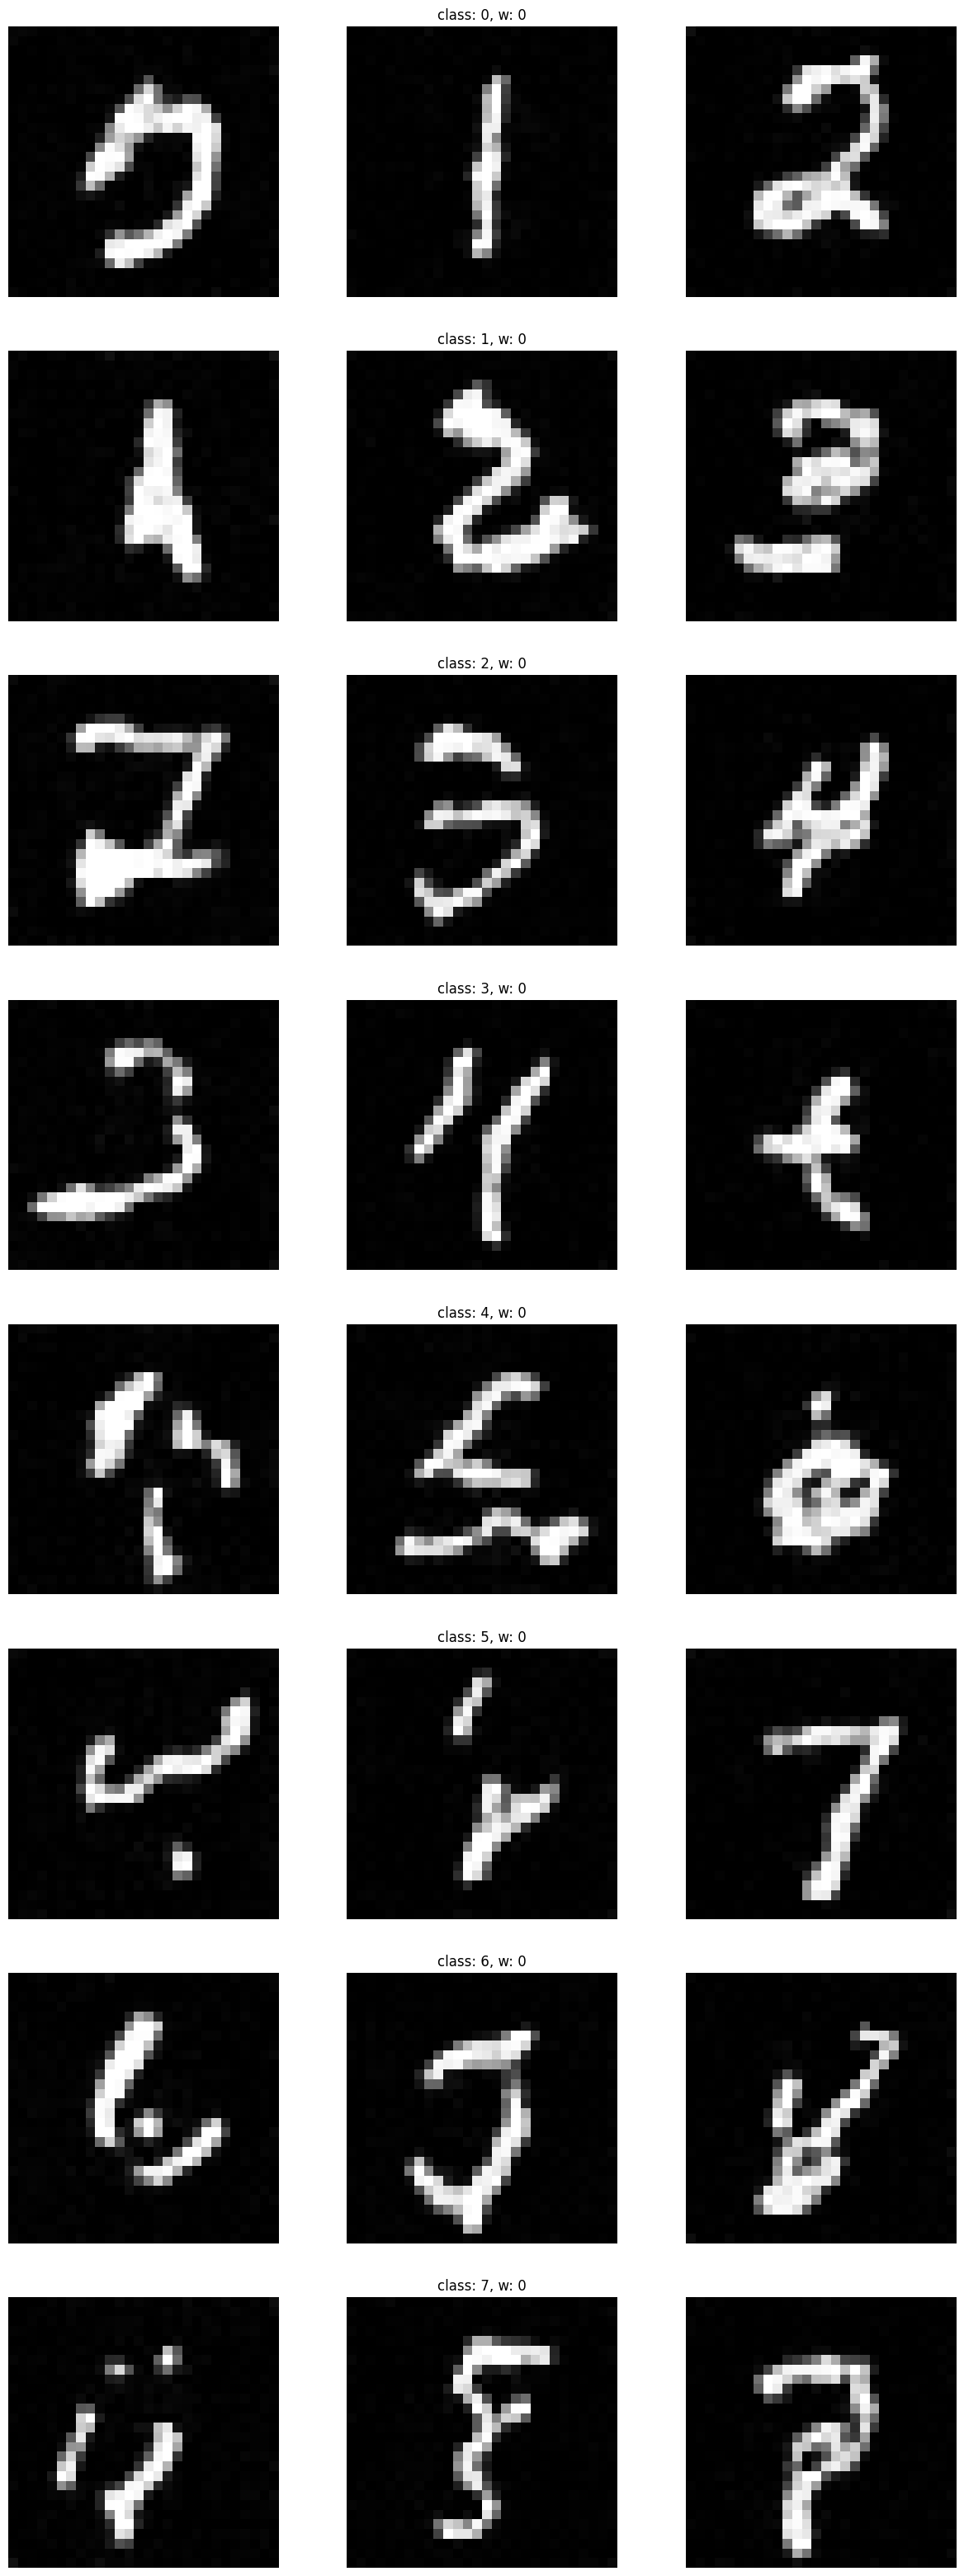

In [ ]:
show_cfg_continous(torch.arange(8), 0)

In [ ]:
print(data.shape)

torch.Size([0])


In [ ]:
#torch.save(model, 'cfg_3d_unet.nn')

In [ ]:
model.load_state_dict(torch.load('cfg_3d_unet.nn').state_dict())

C:\Users\DW21\AppData\Local\Temp\ipykernel_18976\1155087958.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cfg_3d_unet.nn').state_dict

<All keys matched successfully>